In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import category_encoders as ce
from sklearn.preprocessing import FunctionTransformer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col=None)

In [3]:
df.shape

(1460, 81)

In [4]:
test.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1119,2580,190,C (all),75.0,8250,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
125,1586,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,ConLD,Normal
513,1974,60,RL,85.0,10574,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
56,1517,85,RL,75.0,11380,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Shed,1500,1,2010,WD,Normal
970,2431,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
767,2228,20,RL,74.0,11563,Pave,NaN,IR1,HLS,AllPub,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Normal
1257,2718,20,FV,60.0,7180,Pave,Pave,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Normal
231,1692,60,RL,NaN,12891,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
48,1509,60,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,6,2010,WD,Normal
39,1500,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

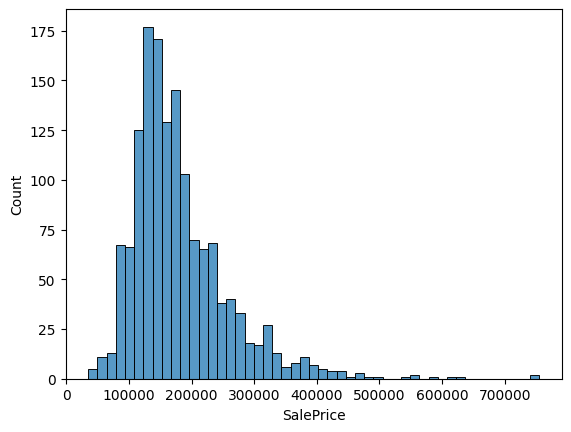

In [7]:
sns.histplot(df.SalePrice)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='SalePrice', ylabel='Count'>

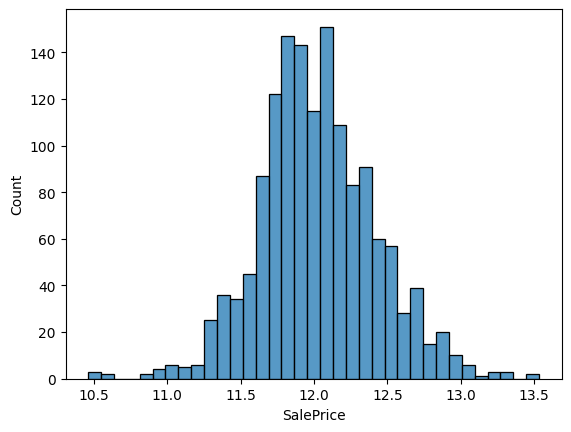

In [8]:
sns.histplot(np.log(df.SalePrice))

In [9]:
numerical_df = df.select_dtypes(include=['number'])


In [10]:
correlations = pd.DataFrame(numerical_df.corr()["SalePrice"].abs().sort_values(ascending=False))

<Axes: >

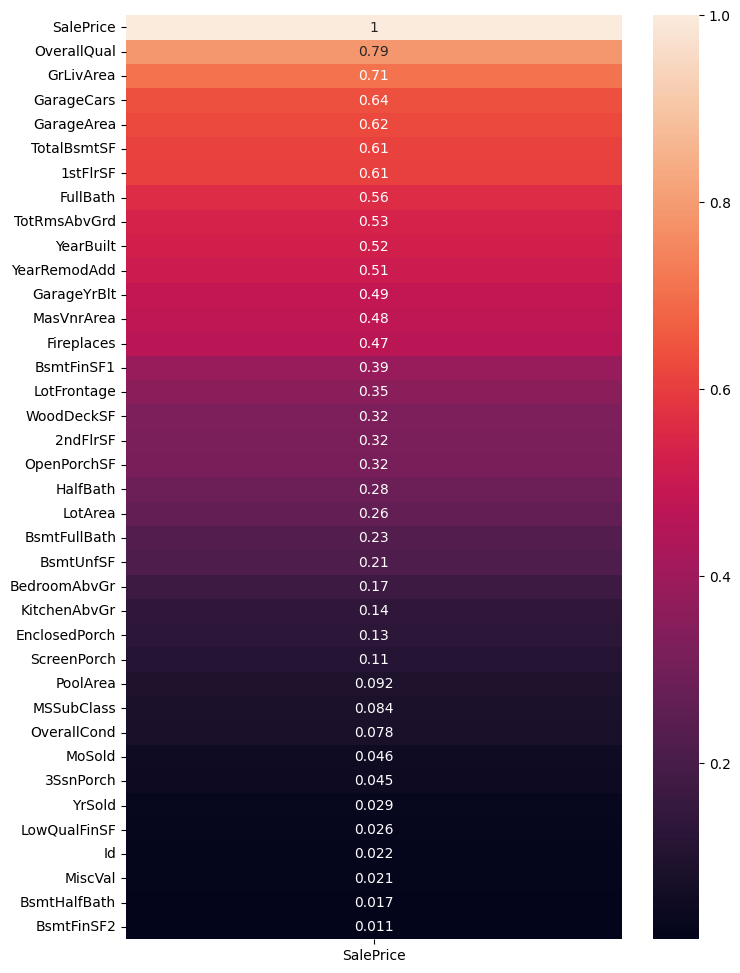

In [11]:
plt.figure(figsize=(8, 12))
sns.heatmap(correlations, annot=True)

In [12]:
low_corr_columns = correlations[correlations["SalePrice"] < 0.1].index.tolist()

In [13]:
non_null_counts = df.count().sort_values(ascending=True)
non_null_counts

PoolQC            7
MiscFeature      54
Alley            91
Fence           281
MasVnrType      588
               ... 
Exterior1st    1460
RoofMatl       1460
RoofStyle      1460
Foundation     1460
SalePrice      1460
Length: 81, dtype: int64

In [14]:
low_count_columns = non_null_counts[non_null_counts<1000].index.tolist()
low_count_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu']

In [15]:
ids = test["Id"]
df = df.drop(low_count_columns + low_corr_columns, axis=1)
test = test.drop(low_count_columns + low_corr_columns, axis=1)

In [16]:
cat_or_card = df.select_dtypes(include="object").nunique().sort_values(ascending=False)

In [17]:
cat_or_card

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
Foundation        6
GarageType        6
Heating           6
BsmtFinType2      6
BsmtFinType1      6
SaleCondition     6
RoofStyle         6
BldgType          5
GarageCond        5
GarageQual        5
Electrical        5
HeatingQC         5
LotConfig         5
MSZoning          5
ExterCond         5
BsmtExposure      4
BsmtCond          4
ExterQual         4
BsmtQual          4
KitchenQual       4
LandContour       4
LotShape          4
LandSlope         3
GarageFinish      3
PavedDrive        3
Utilities         2
Street            2
CentralAir        2
dtype: int64

In [18]:
cardinal_cols = cat_or_card[cat_or_card>7].index.to_list()

['Neighborhood',
 'Exterior2nd',
 'Exterior1st',
 'SaleType',
 'Condition1',
 'Condition2',
 'HouseStyle',
 'RoofMatl',
 'Functional',
 'Foundation',
 'GarageType',
 'Heating',
 'BsmtFinType2',
 'BsmtFinType1',
 'SaleCondition',
 'RoofStyle']

In [20]:
X= df.copy()
y=X.pop("SalePrice")


In [21]:
y=np.log(y)

In [22]:
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols_with_card = X.select_dtypes(include=["object"]).columns.tolist()


In [23]:
cat_cols = [col for col in cat_cols_with_card if col not in cardinal_cols]

In [24]:
scaler = RobustScaler()
target_enc = ce.TargetEncoder(cols=cardinal_cols)

In [25]:
from sklearn.compose import make_column_transformer

In [26]:
X = target_enc.fit_transform(X,y)
test = target_enc.transform(test)

In [27]:
ct = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols),
    (scaler, num_cols),
    remainder="passthrough"
)

In [28]:
X.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch', 'SaleType', 'SaleCondition'],
      dtype='object')

In [29]:
ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['MSZoning', 'Street', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'ExterQual',
                                  'ExterCond', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'HeatingQC', 'CentralAir',
                                  'Electrical', 'KitchenQual', 'GarageFinish',
                                  'Gar...
                                ('robustscaler', RobustScaler(),
                                 ['LotFrontage', 'LotArea', 'OverallQual',
                                  'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                                  'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'GrLivArea',
                                  'BsmtFullBath', 'FullBath', 'HalfBath',
                                  'BedroomAbvGr', 'KitchenAbvGr',
                                  'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
                                  'GarageCars', 'GarageArea', 'WoodDeckSF',
                                  'OpenPorchSF', 'EnclosedPorch',
                                  'ScreenPorch'])])

In [30]:
X = ct.fit_transform(X)
test = ct.transform(test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
#xgb=XGBRegressor(colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, scale_pos_weight=1, subsample=0.8)

In [32]:
#xgb.fit(X,y)

In [33]:
catboost = CatBoostRegressor(depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.05)

In [34]:
catboost.fit(X,y)

0:	learn: 0.3867450	total: 54.2ms	remaining: 1m 21s
1:	learn: 0.3767998	total: 56ms	remaining: 41.9s
2:	learn: 0.3655356	total: 57.6ms	remaining: 28.7s
3:	learn: 0.3538343	total: 59.1ms	remaining: 22.1s
4:	learn: 0.3431401	total: 60.7ms	remaining: 18.1s
5:	learn: 0.3337226	total: 62.4ms	remaining: 15.5s
6:	learn: 0.3243450	total: 64.3ms	remaining: 13.7s
7:	learn: 0.3159035	total: 65.8ms	remaining: 12.3s
8:	learn: 0.3077048	total: 67.3ms	remaining: 11.1s
9:	learn: 0.2993813	total: 68.7ms	remaining: 10.2s
10:	learn: 0.2915114	total: 70.3ms	remaining: 9.52s
11:	learn: 0.2836833	total: 71.8ms	remaining: 8.9s
12:	learn: 0.2769116	total: 73.3ms	remaining: 8.38s
13:	learn: 0.2706191	total: 74.8ms	remaining: 7.94s
14:	learn: 0.2635667	total: 76.4ms	remaining: 7.56s
15:	learn: 0.2568918	total: 77.8ms	remaining: 7.22s
16:	learn: 0.2507334	total: 79.4ms	remaining: 6.92s
17:	learn: 0.2453279	total: 80.8ms	remaining: 6.65s
18:	learn: 0.2402382	total: 82.3ms	remaining: 6.42s
19:	learn: 0.2348958	tot

In [35]:
y_pred = catboost.predict(test)

In [36]:
y_pred = np.exp(y_pred)

In [37]:
output = pd.DataFrame({'Id': ids, 'SalePrice': y_pred})
output.to_csv('submission.csv', index=False)

In [38]:
output

,Id,SalePrice
0,1461,126285.353892
1,1462,161484.867842
2,1463,185784.319158
3,1464,195789.304260
4,1465,186770.588159
...,...,...
1454,2915,74656.517376
1455,2916,78541.859024
1456,2917,146835.976433
1457,2918,109697.949580


In [39]:
output.to_csv("submission.csv", index=False)